In [1]:
import os
import sys
sys.path.append('/home/cyberspace007/mpicek/NeuralMAE')
import numpy as np
import h5py
import torch
import torch.nn as nn
import scipy.io
from scipy.io import savemat
from omegaconf import OmegaConf

import neuralmae.util.misc as misc
import neuralmae.neural_models.models_multimodal_neuralmae_up2 as models_mae_multimodal
import neuralmae.neural_models.models_neuralmae_bsi as models_mae
import neuralmae.dataset.neural_dataset as dataset_n


### Load the data

In [2]:
cfg = OmegaConf.load('/home/cyberspace007/mpicek/NeuralMAE/neuralmae/dataset/config/UP2_multimodal_dataset_clinatec_test.yaml')
#cfg.dataset.transforms.tf.device = args.device # FIXME
#tranform_train = build_transform(is_train=True, cfg=cfg)
dataset_train = dataset_n.Up2MultimodalDatasetClinatec(cfg)

num_tasks = misc.get_world_size()
global_rank = misc.get_rank()
sampler_train = torch.utils.data.DistributedSampler(
    dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=False #FIXME
)
print("Sampler_train = %s" % str(sampler_train))

Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7d22a30dcb60>


In [3]:
# iterate over dataset

for i, data in enumerate(dataset_train):
    if data['video_index'] % 30 != 0:
        continue
    # print(data['acc'].shape)
    print(data.keys())
    print(data['targets']['accelerometer'].shape)
    print(data['data'].shape)
    if i > 10:
        break

dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
torch.Size([30, 3])
torch.Size([24, 32, 10]

### Load model

In [4]:

def prepare_pretrained_brainGPT(chkpt_dir, arch='mae_neut_base_patch245_1implant'):
    #build model
    model = getattr(models_mae, arch)()

    #load model
    chkpt = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(chkpt['model'], strict=False)
    print(msg)
    return model

def prepare_pretrained_brainGPT_multimodal(chkpt_dir):

    freeze_brainGPT = False
    model = models_mae_multimodal.__dict__['mae_neut_conf_tiny_multimodal_mlp_accelerometer'](norm_pix_loss=False,
                                                    norm_session_loss=True,
                                                    uniformity_loss=False,
                                                    lamb=0.01,
                                                    # input_size=tuple(args.input_size), 
                                                    # patch_size=tuple(args.patch_size),
                                                    use_projector=False,
                                                    projector_dim=64,
                                                    freeze_brainGPT=freeze_brainGPT)

    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

    return model


In [5]:

multimodal = True

if multimodal:
    # Multimodal BrainGPT (accelerometer)
    chkpt_dir = "/media/cyberspace007/T7/tmp/training_logs/neuralmae/checkpoints/MLP_predict_ACC_frozen_BrainGPT_one_day/checkpoint-19.pth"
    model_mae = prepare_pretrained_brainGPT_multimodal(chkpt_dir)
    print('Multimodal BrainGPT model loaded.')
else:
    # Vanilla BrainGPT
    chkpt_dir = '/home/cyberspace007/mpicek/NeuralMAE/pretrained_brainGPT/checkpoint-14_up2001.pth'
    model_mae = prepare_pretrained_brainGPT(chkpt_dir, 'mae_neut_base_patch245_1implant')
    print('Vanilla BrainGPT model loaded.')


Number of parameters of the BrainGPT: 110.970265 M
Number of parameters of the Accelerometer MLP Projector: 0.242138 M
Multimodal BrainGPT model loaded.


In [6]:
o = np.ones((30, 3))
# compute mean so that it has shape (1, 3)
mean = np.mean(o, axis=0, keepdims=True)
print(mean.shape)

(1, 3)


In [7]:
len(dataset_train)

1800

### Predict acc - always take the middle value of the second

In [8]:
# extract latents
from tqdm import tqdm
device = torch.device('cuda:0')
model_mae = model_mae.to(device)
model_mae.freeze_brainGPT = True

with torch.no_grad():
    
    model_mae.eval()
    inputs, latents, targets, sessions = [], [], [], []
    acc_pred = []
    acc_target = []

    # for i in tqdm(range(all_data.shape[0])):
    for i, data in tqdm(enumerate(dataset_train)):
        # if data['video_index'] % 30 != 0:
        #     continue


        samp = data['data'].to(device, non_blocking=True, dtype=torch.float32).unsqueeze(0)

        with torch.cuda.amp.autocast():
            loss_reconstruction, pred, multimodal_predictions, mask = model_mae.forward(samp, data['targets']['accelerometer'], mask_ratio=0.00, stats=None)
            # acc_pred.append(multimodal_predictions['accelerometer'].cpu().numpy()[0])
            acc_pred.append(multimodal_predictions['accelerometer'].cpu().numpy()[0][:15])
            acc_target.append(data['targets']['accelerometer'][:15])


    acc_pred = np.concatenate(acc_pred, axis=0)
    acc_target = np.concatenate(acc_target, axis=0)

1800it [00:22, 79.00it/s]


### Quantify how well we can predict the accelerometer (using correlation)

In [9]:
# compute correlation between predicted and target accelerometer
from scipy.stats import pearsonr
correlation = np.zeros((3,))
for i in range(3):
    correlation[i] = pearsonr(acc_target[:, i], acc_pred[:, i])[0]
print(correlation)
print(np.mean(correlation))
#[0.31003799 0.48792669 0.54593304]
#0.44796590835654265

[0.30999343 0.48793526 0.54595374]
0.4479608132764105


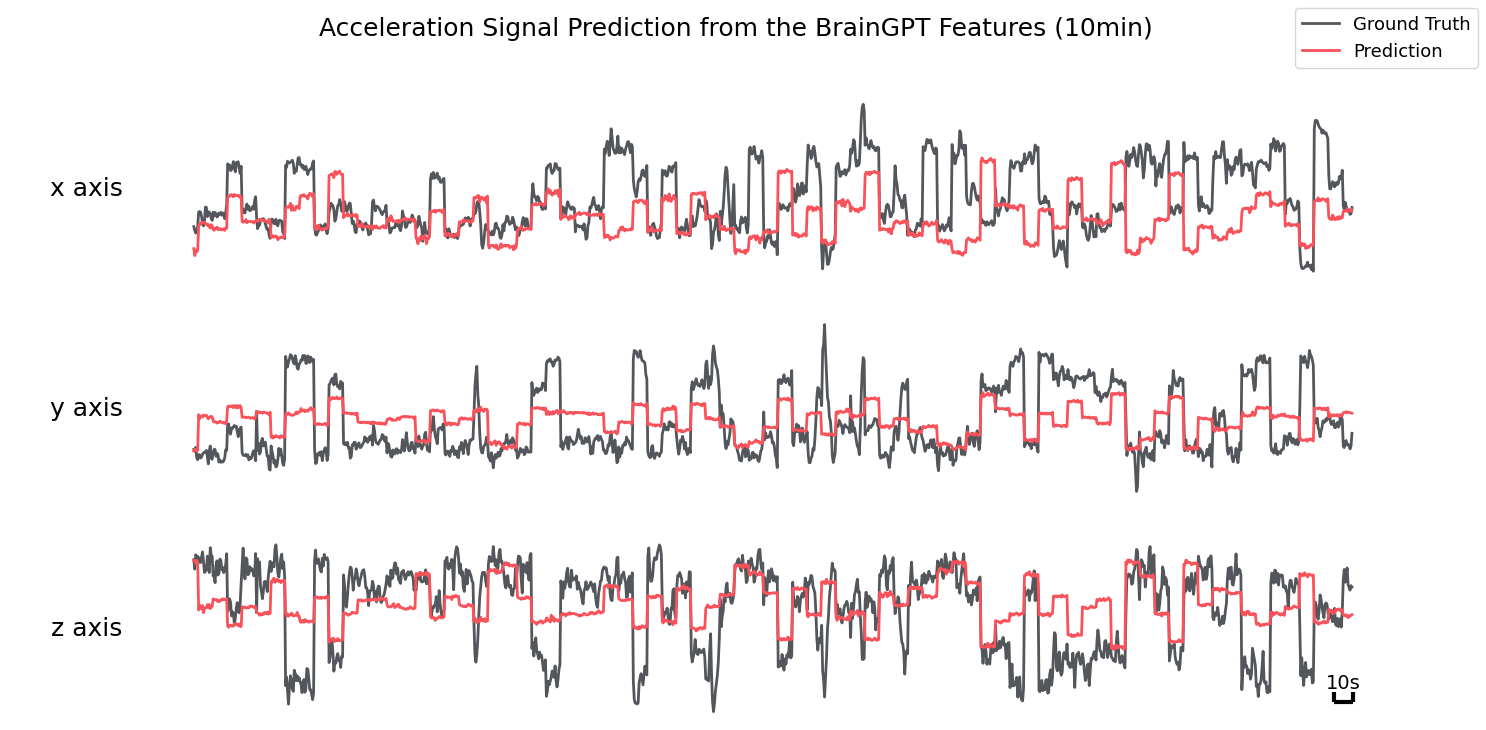

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming acc_target and acc_pred are your data arrays
# Ensure acc_target and acc_pred are numpy arrays and have the same shape
plt.style.use('default')
# Configuration
colors = ['#53565b', '#f9525b']
start = 7000
end = 8200
time_per_point = 0.5  # 0.5 seconds per data point
length_in_seconds = 10  # 10 seconds
y_labels = ["     x axis", "     y axis", "     z axis"]  # y-axis labels

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

# Set a title for the whole figure
fig.suptitle("Acceleration Signal Prediction from the BrainGPT Features (10min)", fontsize=18)

# Generate x values based on the actual indices
x_values = np.arange(start, end)

# Plot each subplot
for i in range(3):
    ax = axes[i]
    ax.plot(x_values, acc_target[start:end, i], label='Ground Truth', color=colors[0], linewidth=2)
    ax.plot(x_values, acc_pred[start:end, i], label='Prediction', color=colors[1], linewidth=2)
    
    # Minimalistic style
    ax.set_facecolor('none')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    # Set y-axis label
    ax.set_ylabel(y_labels[i], rotation=0, labelpad=50, fontsize=18, color='black', va='center')

# Adjusting the horizontal line for 10s of recording
y_min, y_max = ax.get_ylim()
bar_start = end - int(length_in_seconds / time_per_point)  # Adjust for 10 seconds bar
ax.hlines(y=y_min + 0.1*(y_max-y_min), xmin=bar_start, xmax=bar_start + int(length_in_seconds / time_per_point),
            color='black', linestyle='solid', linewidth=3)
ax.vlines(x=bar_start, ymin=y_min + 0.1*(y_max-y_min), ymax=y_min + 0.15*(y_max-y_min),
            color='black', linestyle='solid', linewidth=3)
ax.vlines(x=bar_start + int(length_in_seconds / time_per_point), ymin=y_min + 0.1*(y_max-y_min),
            ymax=y_min + 0.15*(y_max-y_min), color='black', linestyle='solid', linewidth=3)
ax.text(bar_start + int(length_in_seconds / time_per_point) / 2, y_min + 0.15*(y_max-y_min),
        '10s', color='black', ha='center', va='bottom', fontsize=14)

# Add one legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=13)

# Adjust layout to fit all elements
plt.subplots_adjust(left=0.1, right=0.95, top=0.88, bottom=0.1)

# Save the figure
plt.savefig('results/acc_prediction_from_brainGPT.png', format='png', bbox_inches='tight')
plt.savefig('results/acc_prediction_from_brainGPT.svg', format='svg', bbox_inches='tight')

# Display the figure
plt.show()
